In [79]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
from datetime import datetime

import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing

from sklearn.metrics import mean_squared_error
from math import sqrt 

import prepare as prep

from sklearn.impute import SimpleImputer

In [80]:
df = pd.read_csv('GlobalLandTemperaturesByCity.csv')
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


In [81]:
df.shape

(8599212, 7)

In [82]:
df = df.dropna()

In [83]:
df['dt'] = pd.to_datetime(df['dt'])
df = df.set_index('dt').sort_index()

In [84]:
df = df.rename(columns={'AverageTemperature':'avg_temp','AverageTemperatureUncertainty':'avg_temp_unc',
                   'City':'city','Country':'country','Latitude':'lat','Longitude':'long'})

In [85]:
df = df[(df['city']=='Ede') & (df['country']=='Netherlands')]

In [86]:
df_resampled = df.resample('M')[['avg_temp', 'avg_temp_unc']].mean()
df_resampled

,avg_temp,avg_temp_unc
dt,,
1743-11-30,7.431,1.639
1743-12-31,NaN,NaN
1744-01-31,NaN,NaN
1744-02-29,NaN,NaN
1744-03-31,NaN,NaN
...,...,...
2013-04-30,7.710,0.182
2013-05-31,11.464,0.236
2013-06-30,15.043,0.261


In [87]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(df_resampled)

SimpleImputer()

In [88]:
df_resampled = pd.DataFrame(columns=['avg_temp','avg_temp_unc'], data=imp_mean.transform(df_resampled),
                             index=df_resampled.index)
df_resampled

,avg_temp,avg_temp_unc
dt,,
1743-11-30,7.431000,1.63900
1743-12-31,9.130847,1.62833
1744-01-31,9.130847,1.62833
1744-02-29,9.130847,1.62833
1744-03-31,9.130847,1.62833
...,...,...
2013-04-30,7.710000,0.18200
2013-05-31,11.464000,0.23600
2013-06-30,15.043000,0.26100


In [89]:
train_size = int(round(df_resampled.shape[0] * 0.5))

val_size = int(round(df_resampled.shape[0] * 0.3))

test_size = int(round(df_resampled.shape[0] * 0.2))

In [90]:
len(df_resampled) == train_size + val_size + test_size

True

In [91]:
val_end_index = train_size + val_size
val_end_index

2590

In [92]:
train

,avg_temp,avg_temp_unc
dt,,
1743-11-30,7.431,1.639
1743-12-31,NaN,NaN
1744-01-31,NaN,NaN
1744-02-29,NaN,NaN
1744-03-31,NaN,NaN
...,...,...
1878-05-31,12.886,0.535
1878-06-30,15.785,0.988
1878-07-31,16.404,0.464


In [93]:
train = df_resampled[:train_size]

In [94]:
val = df_resampled[train_size:val_end_index]

In [95]:
test = df_resampled[val_end_index:]

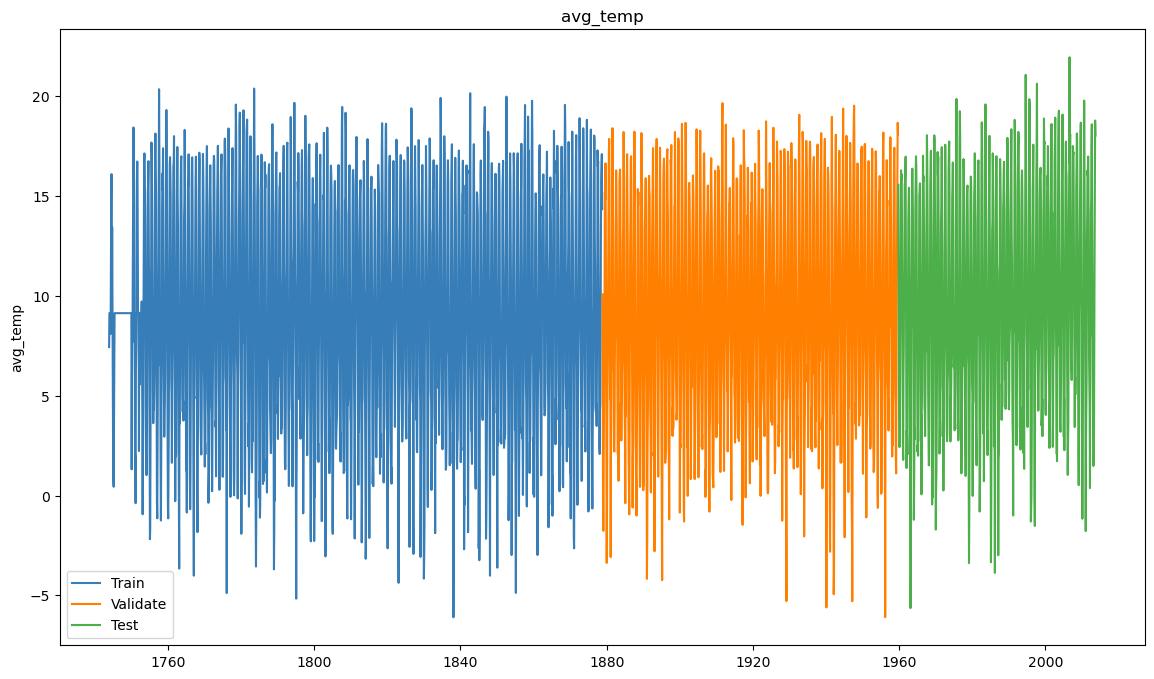

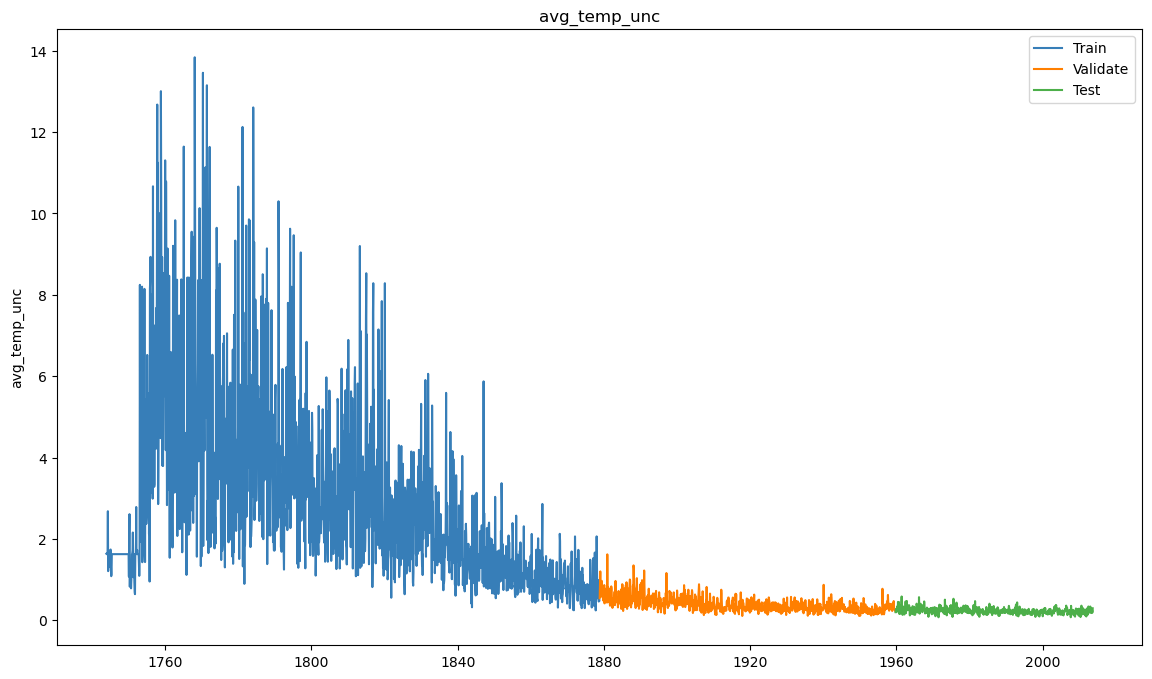

In [96]:
for col in train.columns:
    plt.figure(figsize=(14,8))
    plt.plot(train[col], color='#377eb8', label = 'Train')
    plt.plot(val[col], color='#ff7f00', label = 'Validate')
    plt.plot(test[col], color='#4daf4a', label = 'Test')
    plt.legend()
    plt.ylabel(col)
    plt.title(col)
    plt.show()

In [97]:
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


In [98]:
last_temp = train['avg_temp'][-1:][0]
last_temp_unc = train['avg_temp_unc'][-1:][0]

In [99]:
yhat_df = pd.DataFrame(
    {'avg_temp': last_temp,
     'avg_temp_unc':last_temp_unc},
    index=val.index)

yhat_df.head()

,avg_temp,avg_temp_unc
dt,,
1878-10-31,14.339,0.49
1878-11-30,14.339,0.49
1878-12-31,14.339,0.49
1879-01-31,14.339,0.49
1879-02-28,14.339,0.49


avg_temp -- RMSE: 8


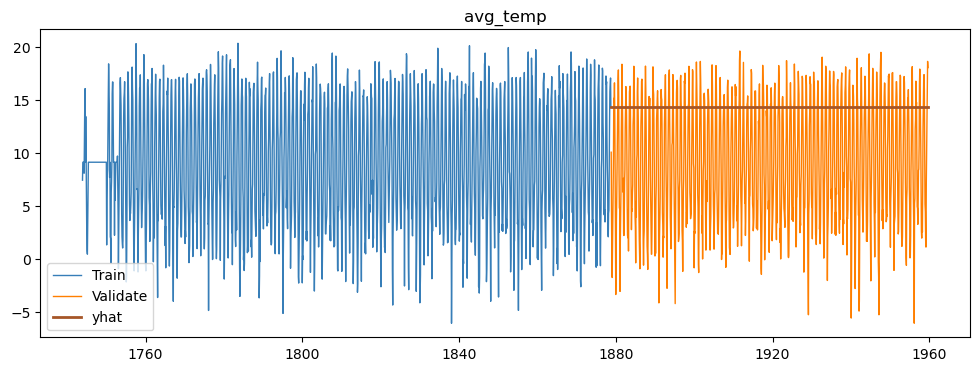

avg_temp_unc -- RMSE: 0


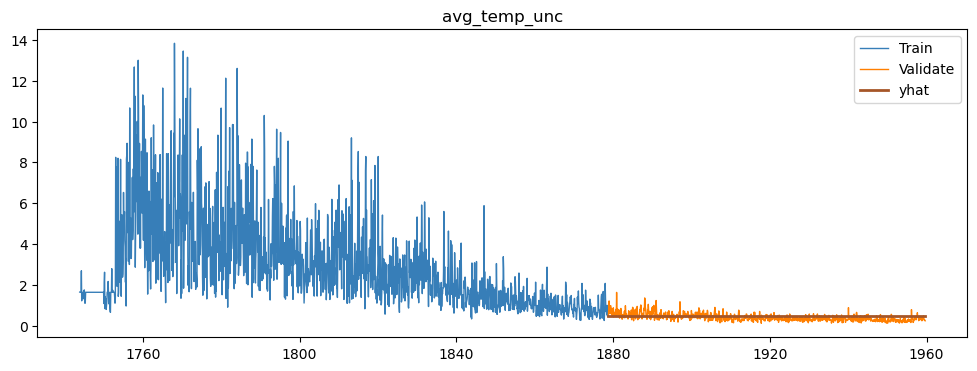

In [100]:
for col in train.columns:
    prep.plot_and_eval(col, train, val, yhat_df)

In [101]:
for col in train.columns:
    eval_df = prep.append_eval_df(model_type = 'last_observed_value', 
                                 target_var = col,
                                 val= val,
                                 yhat_df= yhat_df,
                                 eval_df=eval_df)

eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,8.0
1,last_observed_value,avg_temp_unc,0.0


In [102]:
avg_temp = round(train['avg_temp'].mean(), 2)
avg_temp

8.94

In [103]:
avg_temp_unc = round(train['avg_temp_unc'].mean(), 2)
avg_temp_unc

2.92

In [104]:
def make_baseline_predictions(temp_predictions=None, temp_unc_predictions=None):
    yhat_df = pd.DataFrame({'avg_temp': [temp_predictions],
                           'avg_temp_unc': [temp_unc_predictions]},
                          index=val.index)
    return yhat_df

In [105]:
yhat_df = make_baseline_predictions(avg_temp, avg_temp_unc)

In [106]:
yhat_df.head()

,avg_temp,avg_temp_unc
dt,,
1878-10-31,8.94,2.92
1878-11-30,8.94,2.92
1878-12-31,8.94,2.92
1879-01-31,8.94,2.92
1879-02-28,8.94,2.92


avg_temp -- RMSE: 6


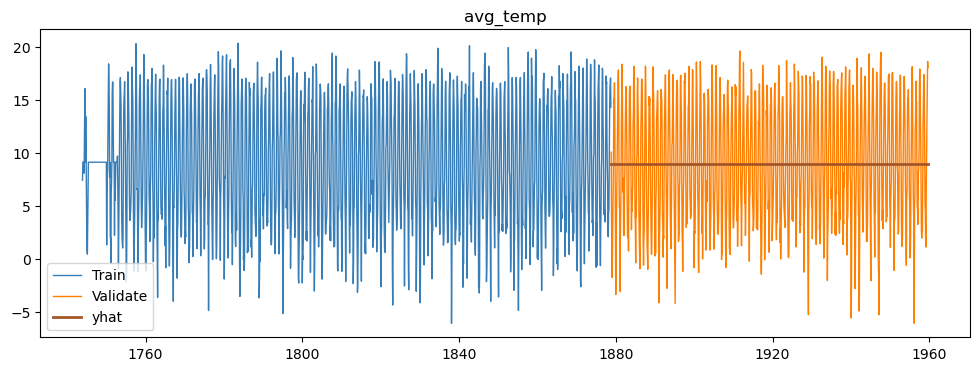

avg_temp_unc -- RMSE: 3


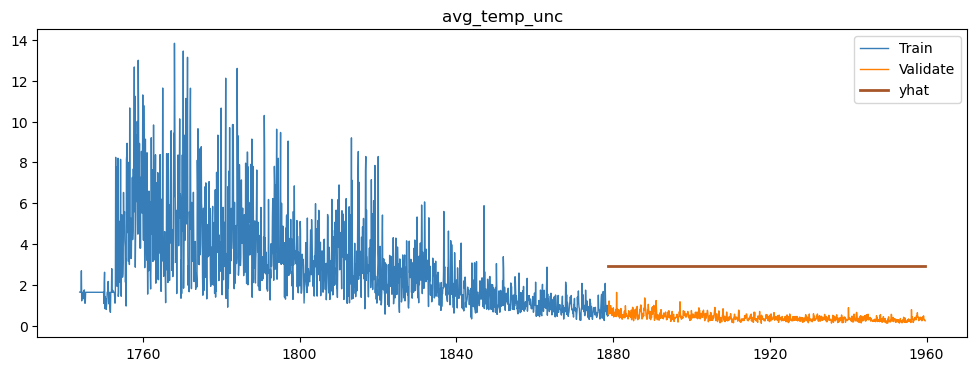

In [107]:
for col in train.columns:
    prep.plot_and_eval(col, train, val, yhat_df)

In [108]:
for col in train.columns:
    eval_df = prep.append_eval_df(model_type = 'simple_average', 
                                 target_var = col,
                                 val= val,
                                 yhat_df= yhat_df,
                                 eval_df=eval_df)

eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,8.0
1,last_observed_value,avg_temp_unc,0.0
2,simple_average,avg_temp,6.0
3,simple_average,avg_temp_unc,3.0


In [109]:
period=3
train['avg_temp'].rolling(period).mean()

dt
1743-11-30          NaN
1743-12-31          NaN
1744-01-31     8.564232
1744-02-29     9.130847
1744-03-31     9.130847
                ...    
1878-05-31     8.986333
1878-06-30    12.721333
1878-07-31    15.025000
1878-08-31    16.427667
1878-09-30    15.945667
Freq: M, Name: avg_temp, Length: 1619, dtype: float64

In [110]:
period=3
train['avg_temp'].rolling(period).mean()[-1]

15.94566666666667

In [111]:
# Saving the last 30 day moving average for each column
rolling_temp = round(train['avg_temp'].rolling(period).mean()[-1], 2)
rolling_temp_unc = round(train['avg_temp_unc'].rolling(period).mean()[-1], 2)
print(rolling_temp, rolling_temp_unc)

15.95 0.49


In [112]:
yhat_df = make_baseline_predictions(rolling_temp, rolling_temp_unc)
yhat_df.head()

,avg_temp,avg_temp_unc
dt,,
1878-10-31,15.95,0.49
1878-11-30,15.95,0.49
1878-12-31,15.95,0.49
1879-01-31,15.95,0.49
1879-02-28,15.95,0.49


avg_temp -- RMSE: 9


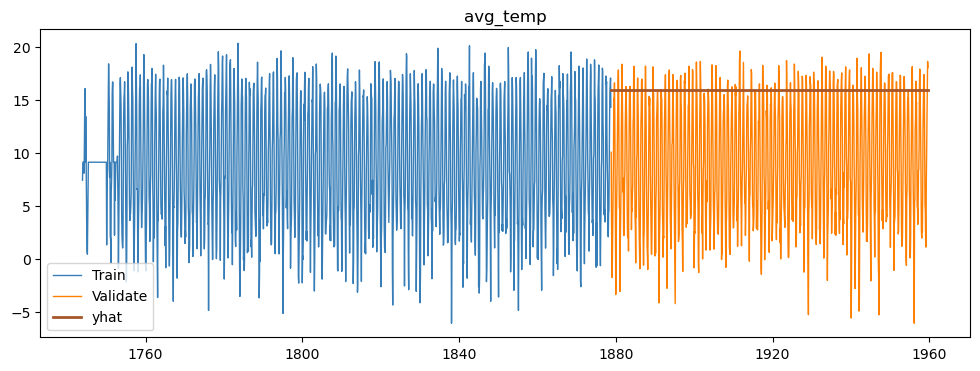

avg_temp_unc -- RMSE: 0


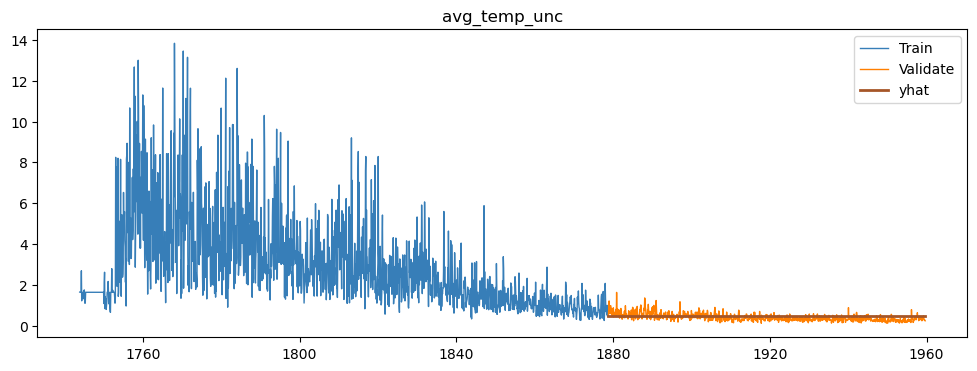

In [113]:
for col in train.columns:
    prep.plot_and_eval(col, train, val, yhat_df)

In [114]:
for col in train.columns:
    eval_df = prep.append_eval_df(model_type = '3m_moving_average', 
                                 target_var = col,
                                 val= val,
                                 yhat_df= yhat_df,
                                 eval_df=eval_df)

eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,8.0
1,last_observed_value,avg_temp_unc,0.0
2,simple_average,avg_temp,6.0
3,simple_average,avg_temp_unc,3.0
4,3m_moving_average,avg_temp,9.0
5,3m_moving_average,avg_temp_unc,0.0


In [115]:
periods = [1,3,4,6,12]

for p in periods: 
    rolling_temp = round(train['avg_temp'].rolling(p).mean()[-1], 2)
    rolling_temp_unc = round(train['avg_temp_unc'].rolling(p).mean()[-1], 2)
    yhat_df = make_baseline_predictions(rolling_temp, rolling_temp_unc)
    model_type = str(p) + 'm_moving_avg'
    for col in train.columns:
        eval_df = prep.append_eval_df(model_type = model_type, 
                                     target_var = col,
                                     val= val,
                                     yhat_df= yhat_df,
                                     eval_df=eval_df)

In [116]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,8.0
1,last_observed_value,avg_temp_unc,0.0
2,simple_average,avg_temp,6.0
3,simple_average,avg_temp_unc,3.0
4,3m_moving_average,avg_temp,9.0
5,3m_moving_average,avg_temp_unc,0.0
6,1m_moving_avg,avg_temp,8.0
7,1m_moving_avg,avg_temp_unc,0.0
8,3m_moving_avg,avg_temp,9.0
9,3m_moving_avg,avg_temp_unc,0.0


In [117]:
best_quantity_rmse = eval_df[eval_df.target_var == 'avg_temp']['rmse'].min()

eval_df[eval_df.rmse == best_quantity_rmse]

,model_type,target_var,rmse
2,simple_average,avg_temp,6.0
14,12m_moving_avg,avg_temp,6.0


In [118]:
best_sales_total_rmse = eval_df[eval_df.target_var == 'avg_temp_unc']['rmse'].min()

eval_df[eval_df.rmse == best_sales_total_rmse]

,model_type,target_var,rmse
1,last_observed_value,avg_temp_unc,0.0
5,3m_moving_average,avg_temp_unc,0.0
7,1m_moving_avg,avg_temp_unc,0.0
9,3m_moving_avg,avg_temp_unc,0.0
11,4m_moving_avg,avg_temp_unc,0.0
13,6m_moving_avg,avg_temp_unc,0.0
15,12m_moving_avg,avg_temp_unc,0.0


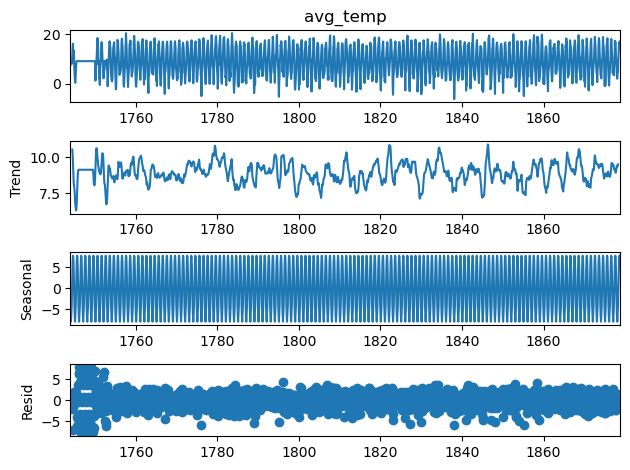

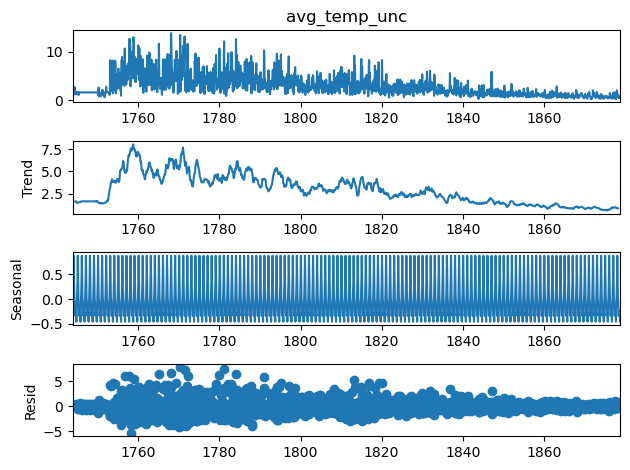

In [119]:
for col in train.columns:
    sm.tsa.seasonal_decompose(train[col].resample('M').mean()).plot()

In [121]:
col = 'avg_temp' 
# create our Holt Object
model = Holt(train[col], exponential=False, damped=True)

In [122]:
model = model.fit(optimized=True)

In [124]:
yhat_temp_total = model.predict(start = val.index[0],
                              end = val.index[-1])

In [125]:
# doing this in a loop for each column
for col in train.columns:
    model = Holt(train[col], exponential=False, damped=True)
    model = model.fit(optimized=True)
    yhat_values = model.predict(start = val.index[0],
                              end = val.index[-1])
    yhat_df[col] = round(yhat_values, 2)

avg_temp -- RMSE: 6


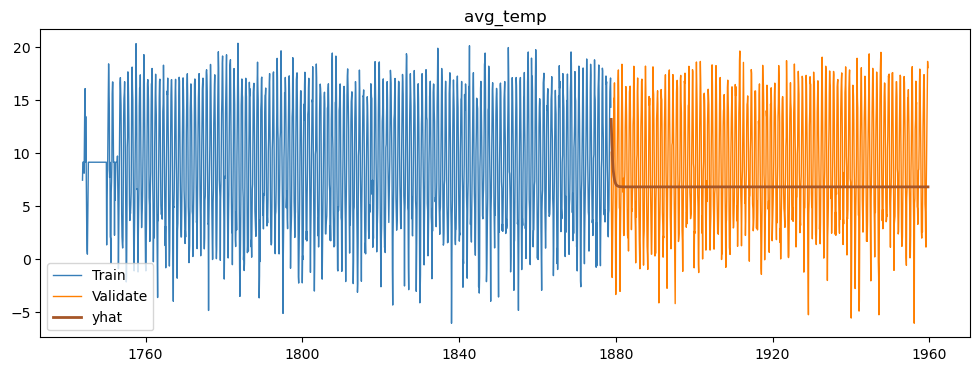

avg_temp_unc -- RMSE: 0


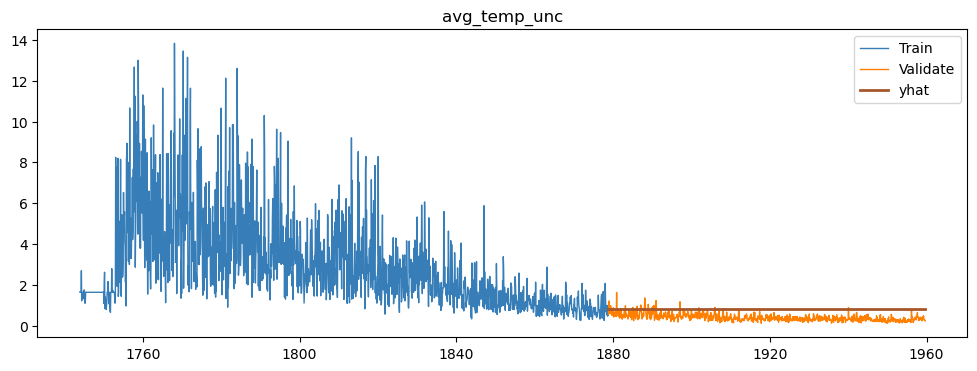

In [126]:
for col in train.columns:
    prep.plot_and_eval(col, train, val, yhat_df)

In [127]:
for col in train.columns:
    eval_df = prep.append_eval_df(model_type = 'holts_optimized', 
                                 target_var = col,
                                 val= val,
                                 yhat_df= yhat_df,
                                 eval_df=eval_df)

eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,8.0
1,last_observed_value,avg_temp_unc,0.0
2,simple_average,avg_temp,6.0
3,simple_average,avg_temp_unc,3.0
4,3m_moving_average,avg_temp,9.0
5,3m_moving_average,avg_temp_unc,0.0
6,1m_moving_avg,avg_temp,8.0
7,1m_moving_avg,avg_temp_unc,0.0
8,3m_moving_avg,avg_temp,9.0
9,3m_moving_avg,avg_temp_unc,0.0


In [128]:
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
17,holts_optimized,avg_temp_unc,0.0
1,last_observed_value,avg_temp_unc,0.0
15,12m_moving_avg,avg_temp_unc,0.0
5,3m_moving_average,avg_temp_unc,0.0
7,1m_moving_avg,avg_temp_unc,0.0
9,3m_moving_avg,avg_temp_unc,0.0
13,6m_moving_avg,avg_temp_unc,0.0
11,4m_moving_avg,avg_temp_unc,0.0
3,simple_average,avg_temp_unc,3.0
2,simple_average,avg_temp,6.0


In [131]:
# Models for temperature
hst_temp_fit1 = ExponentialSmoothing(train['avg_temp'], seasonal_periods=12, trend='add', seasonal='add').fit()
hst_temp_fit2 = ExponentialSmoothing(train['avg_temp'], seasonal_periods=12, trend='add', seasonal='add', damped=True).fit()

# Models for temperature uncertainty
hst_temp_unc_fit1 = ExponentialSmoothing(train['avg_temp_unc'], seasonal_periods=12, trend='add', seasonal='add').fit()
hst_temp_unc_fit2 = ExponentialSmoothing(train['avg_temp_unc'], seasonal_periods=12, trend='add', seasonal='add', damped=True).fit()

In [132]:
results_temp=pd.DataFrame({'model':['hst_temp_fit1', 'hst_temp_fit2'],
                              'SSE':[hst_temp_fit1.sse, hst_temp_fit2.sse]})
results_temp

,model,SSE
0,hst_temp_fit1,6181.716832
1,hst_temp_fit2,6154.138269


In [133]:
results_temp_unc=pd.DataFrame({'model':['hst_temp_unc_fit1', 'hst_temp_unc_fit2'],
                              'SSE':[hst_temp_unc_fit1.sse, hst_temp_unc_fit2.sse]})
results_temp_unc

,model,SSE
0,hst_temp_unc_fit1,4035.604344
1,hst_temp_unc_fit2,4029.010499


In [134]:
yhat_df = pd.DataFrame({'avg_temp': hst_temp_fit2.forecast(val.shape[0]),
                           'avg_temp_unc': hst_temp_unc_fit2.forecast(val.shape[0])},
                          index=val.index)
yhat_df

,avg_temp,avg_temp_unc
dt,,
1878-10-31,9.492043,0.695243
1878-11-30,5.047457,0.980998
1878-12-31,2.102532,1.196698
1879-01-31,2.082659,1.730890
1879-02-28,2.879432,1.378988
...,...,...
1959-04-30,8.391326,0.810434
1959-05-31,11.340231,0.528348
1959-06-30,15.677603,0.554564


avg_temp -- RMSE: 2


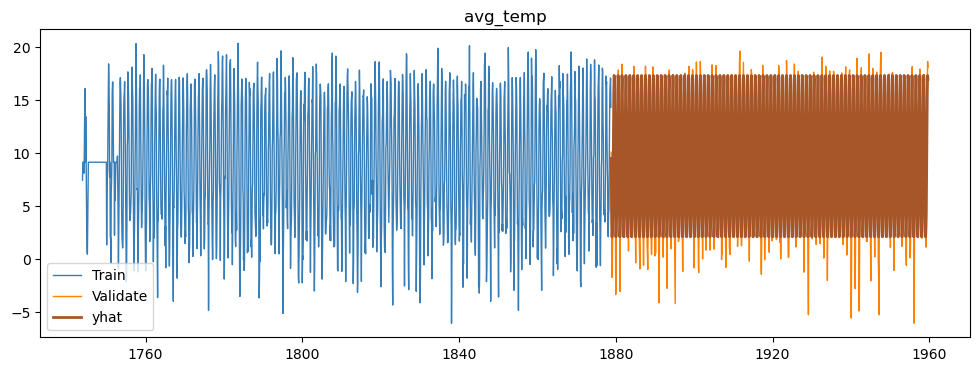

avg_temp_unc -- RMSE: 1


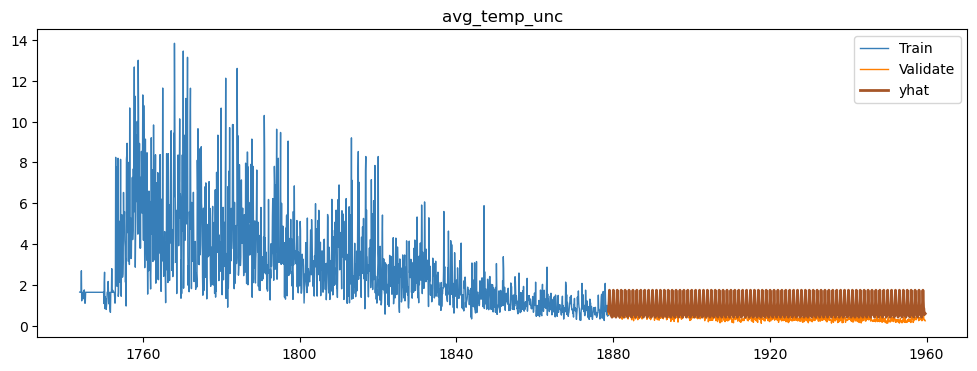

In [135]:
for col in train.columns:
    prep.plot_and_eval(col, train, val, yhat_df)

In [136]:
for col in train.columns:
    eval_df = prep.append_eval_df(model_type = 'holts_seasonal_add_add', 
                                 target_var = col,
                                 val= val,
                                 yhat_df= yhat_df,
                                 eval_df=eval_df)

eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,8.0
1,last_observed_value,avg_temp_unc,0.0
2,simple_average,avg_temp,6.0
3,simple_average,avg_temp_unc,3.0
4,3m_moving_average,avg_temp,9.0
5,3m_moving_average,avg_temp_unc,0.0
6,1m_moving_avg,avg_temp,8.0
7,1m_moving_avg,avg_temp_unc,0.0
8,3m_moving_avg,avg_temp,9.0
9,3m_moving_avg,avg_temp_unc,0.0


In [137]:
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
9,3m_moving_avg,avg_temp_unc,0.0
1,last_observed_value,avg_temp_unc,0.0
17,holts_optimized,avg_temp_unc,0.0
15,12m_moving_avg,avg_temp_unc,0.0
13,6m_moving_avg,avg_temp_unc,0.0
5,3m_moving_average,avg_temp_unc,0.0
11,4m_moving_avg,avg_temp_unc,0.0
7,1m_moving_avg,avg_temp_unc,0.0
19,holts_seasonal_add_add,avg_temp_unc,1.0
18,holts_seasonal_add_add,avg_temp,2.0


In [146]:
df_resampled['201']

,avg_temp,avg_temp_unc
dt,,
2013-01-31,1.479,0.217
2013-02-28,1.559,0.304
2013-03-31,2.253,0.267
2013-04-30,7.710,0.182
2013-05-31,11.464,0.236
2013-06-30,15.043,0.261
2013-07-31,18.775,0.193
2013-08-31,18.025,0.298


In [154]:
train = df_resampled[:'2010']
val = df_resampled['2011']
test = df_resampled['2012':'2012']

print(train.shape)
print(val.shape)
print(test.shape)

train.head()
train.tail()

(3206, 2)
(12, 2)
(12, 2)


,avg_temp,avg_temp_unc
dt,,
2010-08-31,16.912,0.222
2010-09-30,13.661,0.194
2010-10-31,10.279,0.149
2010-11-30,5.385,0.261
2010-12-31,-1.778,0.300


In [159]:
yhat_df = train['2010'] + train.diff(12).mean()
yhat_df

,avg_temp,avg_temp_unc
dt,,
2010-01-31,-1.166519,0.263691
2010-02-28,1.175481,0.196691
2010-03-31,6.078481,0.180691
2010-04-30,9.157481,0.076691
2010-05-31,10.356481,0.131691
2010-06-30,16.206481,0.250691
2010-07-31,19.768481,0.356691
2010-08-31,16.905481,0.216691
2010-09-30,13.654481,0.188691


In [160]:
pd.concat([yhat_df.head(1), val.head(1)])

,avg_temp,avg_temp_unc
dt,,
2010-01-31,-1.166519,0.263691
2011-01-31,2.934000,0.237000


In [161]:
yhat_df.index = val.index

avg_temp -- RMSE: 3


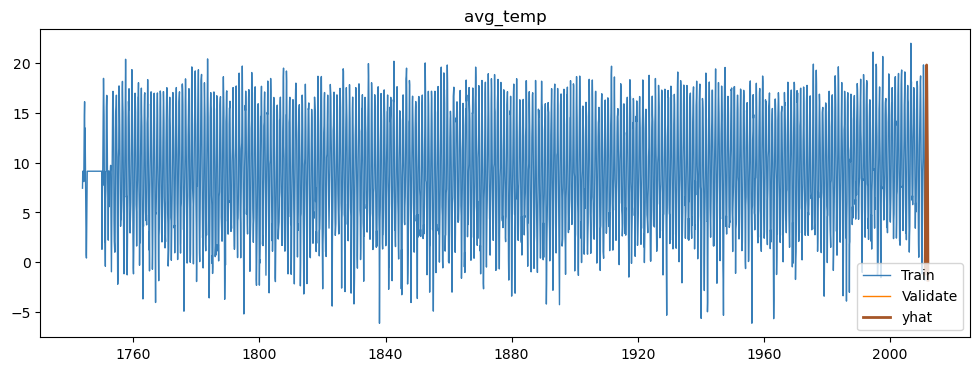

avg_temp_unc -- RMSE: 0


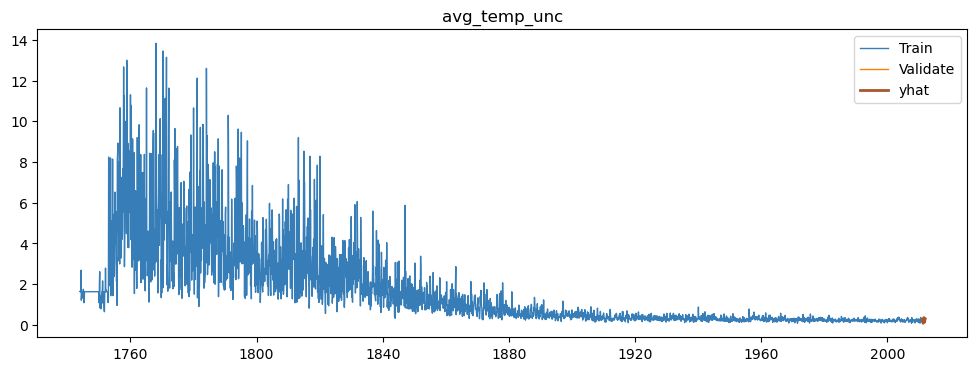

In [162]:
for col in train.columns:
    prep.plot_and_eval(col, train, val, yhat_df)
    eval_df = prep.append_eval_df(model_type = 'previous_year', 
                                 target_var = col,
                                 val= val,
                                 yhat_df= yhat_df,
                                 eval_df=eval_df)

In [165]:
eval_df.sort_values('rmse')

,model_type,target_var,rmse
21,previous_year,avg_temp_unc,0.0
1,last_observed_value,avg_temp_unc,0.0
5,3m_moving_average,avg_temp_unc,0.0
7,1m_moving_avg,avg_temp_unc,0.0
17,holts_optimized,avg_temp_unc,0.0
9,3m_moving_avg,avg_temp_unc,0.0
11,4m_moving_avg,avg_temp_unc,0.0
13,6m_moving_avg,avg_temp_unc,0.0
15,12m_moving_avg,avg_temp_unc,0.0
19,holts_seasonal_add_add,avg_temp_unc,1.0


In [166]:
temp_min_rmse = eval_df.groupby('target_var')['rmse'].min()[0]

temp_unc_min_rmse = eval_df.groupby('target_var')['rmse'].min()[1]

# find which model that is
eval_df[((eval_df.rmse == temp_min_rmse) | 
         (eval_df.rmse == temp_unc_min_rmse))]

,model_type,target_var,rmse
1,last_observed_value,avg_temp_unc,0.0
5,3m_moving_average,avg_temp_unc,0.0
7,1m_moving_avg,avg_temp_unc,0.0
9,3m_moving_avg,avg_temp_unc,0.0
11,4m_moving_avg,avg_temp_unc,0.0
13,6m_moving_avg,avg_temp_unc,0.0
15,12m_moving_avg,avg_temp_unc,0.0
17,holts_optimized,avg_temp_unc,0.0
18,holts_seasonal_add_add,avg_temp,2.0
21,previous_year,avg_temp_unc,0.0


In [167]:
train = df_resampled[:train_size]
val = df_resampled[train_size:val_end_index]
test = df_resampled[val_end_index:]

In [168]:
yhat_df = pd.DataFrame({'avg_temp': hst_temp_fit2.forecast(val.shape[0] + test.shape[0]),
                           'avg_temp_unc': hst_temp_unc_fit1.forecast(val.shape[0] + test.shape[0])})
yhat_df

,avg_temp,avg_temp_unc
1878-10-31,9.492043,0.692093
1878-11-30,5.047457,0.975608
1878-12-31,2.102532,1.191084
1879-01-31,2.082659,1.725056
1879-02-28,2.879432,1.372998
...,...,...
2013-04-30,8.391326,0.139066
2013-05-31,11.340231,-0.143270
2013-06-30,15.677603,-0.117345
2013-07-31,17.334491,-0.060454


In [169]:
test.head(1)

,avg_temp,avg_temp_unc
dt,,
1959-09-30,15.552,0.202


In [174]:
yhat_df = yhat_df['1959-09-30':]

In [175]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], color='#377eb8', label='train')
    plt.plot(val[target_var], color='#ff7f00', label='validate')
    plt.plot(test[target_var], color='#4daf4a',label='test')
    plt.plot(yhat_df[target_var], color='#a65628', label='yhat')
    plt.legend()
    plt.title(target_var)
    plt.show()

In [176]:
rmse_temp_avg = sqrt(mean_squared_error(test['avg_temp'], 
                                       yhat_df['avg_temp']))

rmse_temp_unc = sqrt(mean_squared_error(test['avg_temp_unc'], 
                                       yhat_df['avg_temp_unc']))

FINAL PERFORMANCE OF MODEL ON TEST DATA
rmse-average temp:  1.8545282638365352
rmse-temp uncertainty:  0.40489982888294174


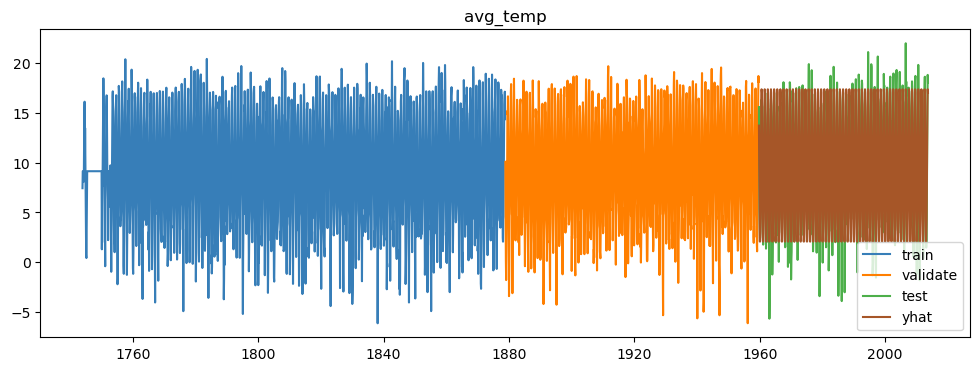

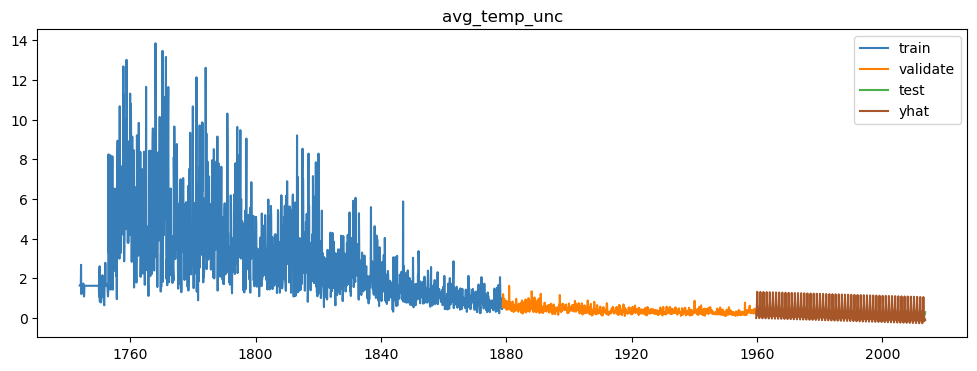

In [180]:
print('FINAL PERFORMANCE OF MODEL ON TEST DATA')
print('rmse-average temp: ', rmse_temp_avg)
print('rmse-temp uncertainty: ', rmse_temp_unc)
for col in train.columns:
    final_plot(col)

In [183]:
forecast = pd.DataFrame({'avg_temp': hst_temp_fit2.forecast(val.shape[0] + test.shape[0] + 60),
                           'avg_temp_unc': hst_temp_unc_fit1.forecast(val.shape[0] + test.shape[0] + 60)})
forecast = forecast['2013':]
forecast

,avg_temp,avg_temp_unc
2013-01-31,2.082659,1.060187
2013-02-28,2.879432,0.708128
2013-03-31,4.415731,0.211753
2013-04-30,8.391326,0.139066
2013-05-31,11.340231,-0.143270
...,...,...
2018-04-30,8.391326,0.114257
2018-05-31,11.340231,-0.168079
2018-06-30,15.677603,-0.142154
2018-07-31,17.334491,-0.085262


In [188]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train['1860':][target_var], color='#377eb8', label='Train')
    plt.plot(val[target_var], color='#ff7f00', label='Validate')
    plt.plot(test[target_var], color='#4daf4a', label='Test')
    plt.plot(yhat_df[target_var], color='#a65628', label='yhat')
    plt.plot(forecast[target_var], color='#984ea3', label='Forecast')
    plt.title(target_var)
    plt.legend()
    plt.show()

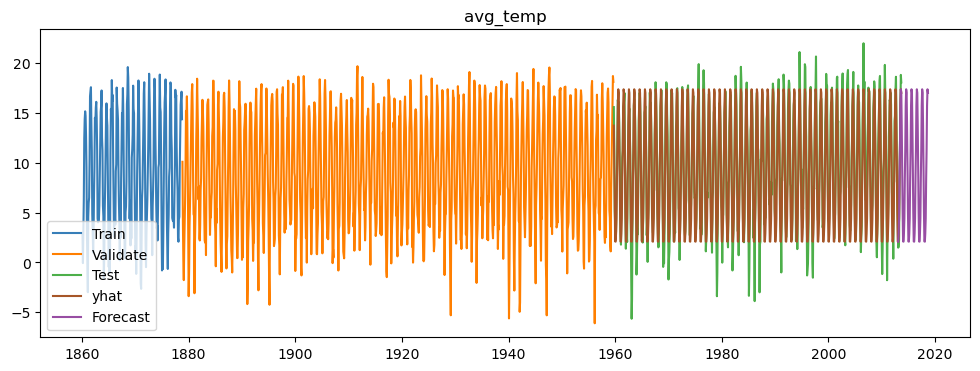

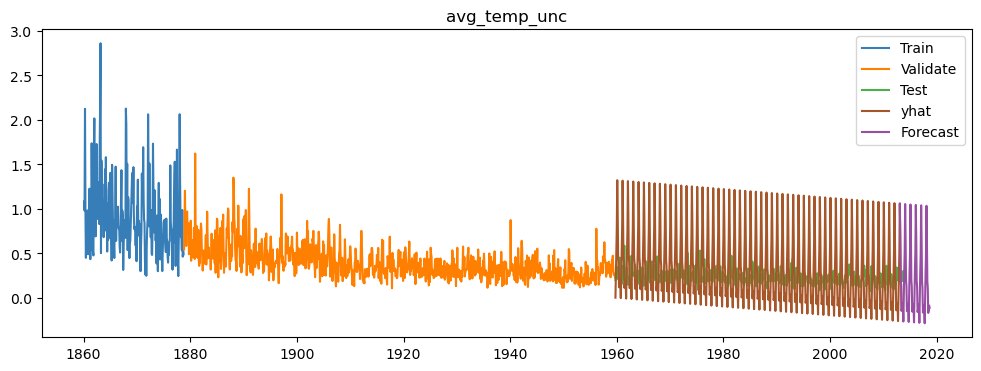

In [189]:
for col in train.columns:
    final_plot(col)